# Image recognition in Julia

In [1]:
using Pkg; Pkg.activate(pwd())

  Activating project at `/media/yuehhua/Workbench/workspace/image-recognition.jl`


## Introduction to Flux

### Linear regression

In [2]:
using Flux
using Flux.Optimise: update!
using DelimitedFiles: readdlm

In [3]:
isfile("housing.data") ||
  download("https://raw.githubusercontent.com/MikeInnes/notebooks/master/housing.data", "housing.data")

true

#### Read data

In [4]:
rawdata = readdlm("housing.data")'

14×505 adjoint(::Matrix{Float64}) with eltype Float64:
   0.02731    0.02729    0.03237  …    0.06076    0.10959    0.04741
   0.0        0.0        0.0           0.0        0.0        0.0
   7.07       7.07       2.18         11.93      11.93      11.93
   0.0        0.0        0.0           0.0        0.0        0.0
   0.469      0.469      0.458         0.573      0.573      0.573
   6.421      7.185      6.998    …    6.976      6.794      6.03
  78.9       61.1       45.8          91.0       89.3       80.8
   4.9671     4.9671     6.0622        2.1675     2.3889     2.505
   2.0        2.0        3.0           1.0        1.0        1.0
 242.0      242.0      222.0         273.0      273.0      273.0
  17.8       17.8       18.7      …   21.0       21.0       21.0
 396.9      392.83     394.63        396.9      393.45     396.9
   9.14       4.03       2.94          5.64       6.48       7.88
  21.6       34.7       33.4          23.9       22.0       11.9

In [5]:
x = rawdata[1:13,:]
y = rawdata[14:14,:]

1×505 Matrix{Float64}:
 21.6  34.7  33.4  36.2  28.7  22.9  …  16.8  22.4  20.6  23.9  22.0  11.9

In [6]:
using Statistics
x = (x .- mean(x; dims=2)) ./ std(x; dims=2)

13×505 Matrix{Float64}:
 -0.417416  -0.417418  -0.416828  …  -0.41353   -0.407858  -0.415081
 -0.486234  -0.486234  -0.486234     -0.486234  -0.486234  -0.486234
 -0.595732  -0.595732  -1.30899       0.11315    0.11315    0.11315
 -0.272618  -0.272618  -0.272618     -0.272618  -0.272618  -0.272618
 -0.739098  -0.739098  -0.833934      0.15753    0.15753    0.15753
  0.194741   1.28121    1.01528   …   0.983996   0.725177  -0.361293
  0.366208  -0.265527  -0.808535      0.795646   0.735312   0.433641
  0.556346   0.556346   1.0759       -0.771891  -0.66685   -0.611768
 -0.868939  -0.868939  -0.754097     -0.983782  -0.983782  -0.983782
 -0.987128  -0.987128  -1.10573      -0.803294  -0.803294  -0.803294
 -0.306024  -0.306024   0.110158  …   1.17373    1.17373    1.17373
  0.441136   0.396591   0.416291      0.441136   0.403377   0.441136
 -0.494157  -1.20985   -1.36251      -0.984357  -0.866709  -0.670629

#### Model

In [7]:
in_dim = size(x, 1)
out_dim = size(y, 1);

In [8]:
predict(x) = W*x .+ b
W = randn(out_dim, in_dim) / 10
b = zeros(out_dim)

1-element Vector{Float64}:
 0.0

In [9]:
error(ŷ, y) = sum((ŷ .- y).^2)/size(y, 2)

error (generic function with 1 method)

In [10]:
loss(x, y) = error(predict(x), y)

loss (generic function with 1 method)

#### Training

In [11]:
η = 0.01 # Learning Rate
θ = Flux.params(W, b)
for i = 1:50
    grads = gradient(() -> loss(x, y), θ)
    for p in (W, b)
      update!(p, η * grads[p])
    end
    @show loss(x, y)
end

LoadError: UndefVarError: depwarn not defined

#### Predict

In [13]:
predict(x[:, 1]) / y[1]

LoadError: UndefVarError: W not defined

## Training image recognition model

In [1]:
using Flux
using Flux: @epochs, onehotbatch, onecold, crossentropy, throttle
using Flux.Data: DataLoader
using Base.Iterators: repeated, partition
using Statistics: mean
using MLDatasets
using ProgressMeter: @showprogress
using CUDA

#### Load data and preprocessing

In [2]:
batch_size = 128

128

In [3]:
function get_data(batchsize)
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 1 method)

In [4]:
train_loader, test_loader = get_data(batch_size)

(DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 10, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}(([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0]), 128, 60000, true, true, Random._GLOBAL_RNG()), DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 10, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}(([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.

#### Model

In [15]:
model = Chain(
    Conv((5, 5), 1=>6, relu),
    MaxPool((2, 2)),
    Conv((5, 5), 6=>16, relu),
    MaxPool((2, 2)),
    Flux.flatten,
    Dense(256, 10), softmax)

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 5_142 parameters, 21.164 KiB.

#### Loss function

In [6]:
loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [7]:
accuracy(x, y) = mean(onecold(model(x) |> cpu) .== onecold(y |> cpu))
accuracy(loader, device) = mean(accuracy(x |> device, y |> device) for (x, y) in loader)

accuracy (generic function with 1 method)

#### Optimizer

In [8]:
opt = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

#### Training

In [9]:
device = cpu
ps = Flux.params(model);

In [16]:
for epoch in 1:10
    @showprogress for (x, y) in train_loader
        x, y = x |> device, y |> device
        gs = Flux.gradient(ps) do
            ŷ = model(x)
            loss(ŷ, y)
        end

        Flux.Optimise.update!(opt, ps, gs)
    end

    @show accuracy(test_loader, device)
end

LoadError: DimensionMismatch("Rank of x and w must match! (2 vs. 4)")

## Use pre-trained models

In [18]:
using Metalhead, Images

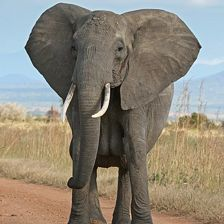

In [19]:
vgg = VGG19()
sample = load("Elephant.jpg")

In [35]:
img = Float32.(cat(red.(sample), green.(sample), blue.(sample), dims=3))
img = reshape(img, size(img)..., 1)

224×224×3×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.666667  0.670588  0.670588  0.67451   …  0.737255  0.729412  0.729412
 0.670588  0.670588  0.670588  0.67451      0.729412  0.729412  0.729412
 0.670588  0.670588  0.670588  0.67451      0.729412  0.729412  0.729412
 0.670588  0.670588  0.67451   0.67451      0.721569  0.729412  0.721569
 0.67451   0.67451   0.67451   0.678431     0.709804  0.713726  0.713726
 0.67451   0.67451   0.67451   0.678431  …  0.701961  0.701961  0.698039
 0.67451   0.67451   0.678431  0.678431     0.686275  0.690196  0.682353
 0.67451   0.67451   0.678431  0.678431     0.678431  0.67451   0.67451
 0.682353  0.682353  0.682353  0.682353     0.682353  0.682353  0.682353
 0.682353  0.682353  0.682353  0.682353     0.686275  0.686275  0.686275
 0.682353  0.682353  0.682353  0.682353  …  0.690196  0.690196  0.690196
 0.682353  0.682353  0.682353  0.682353     0.690196  0.690196  0.690196
 0.682353  0.682353  0.682353  0.682353     0.694118  0.694118  0.694118
 ⋮    

In [36]:
vgg(img)

1000×1 Matrix{Float32}:
 -7.537028f-5
 -0.0008947532
  0.00043272632
  4.348868f-5
  0.00017289813
  0.00030598807
 -4.529599f-5
 -0.00021264839
 -0.00011824549
 -0.00013643049
 -3.6215264f-5
 -0.00022971808
  0.00012411491
  ⋮
 -0.00027687455
  0.00026358993
  0.00031917496
 -0.00019717486
 -8.1116916f-5
 -0.00023616159
  0.00018659615
 -0.0003579578
 -0.00036433627
  0.00014160757
 -0.00020240946
  1.1184005f-5

In [37]:
x = rand(Float32, 224, 224, 3, 1)
vgg(x)

1000×1 Matrix{Float32}:
 -0.00016178077
 -0.0016609447
  0.000609078
  7.068464f-5
  0.00032518146
  0.00051235734
  9.861344f-5
 -0.0003474876
 -0.0003052402
 -0.00025615905
 -0.000147335
 -0.0005039692
  0.0004292742
  ⋮
 -0.00046178952
  0.00039073656
  0.00048951246
 -0.00048149948
 -0.00017220539
 -0.0005026239
  0.00031568002
 -0.0006796546
 -0.0007599739
  0.00020180986
 -0.00031208963
  0.00015428527

In [38]:
vgg.layers

Chain(
  Chain([
    Conv((3, 3), 3 => 64, relu, pad=1),  # 1_792 parameters
    Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
    MaxPool((2, 2)),
    Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
    Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
    MaxPool((2, 2)),
    Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
    Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
    Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
    Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
    MaxPool((2, 2)),
    Conv((3, 3), 256 => 512, relu, pad=1),  # 1_180_160 parameters
    Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
    Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
    Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
    MaxPool((2, 2)),
    Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
    Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_80